In [2]:
#library 
import pandas as pd 
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import os
from time import time
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

#statsmodels
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.metrics import smape

#for korean
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)
%config InlineBackend.figure_format='retina'

#show .5f
pd.options.display.float_format = '{:.5f}'.format
#show all columns
pd.set_option('display.max.columns', None)

# DATA

In [5]:
#제공데이터를 합병한 데이터
df = pd.read_csv("Z:/team/dataset/제공데이터_merge+기온,강수량,cpi,gdp,천연가스수입.csv",index_col='Unnamed: 0',parse_dates=True)
#제공데이터와 기온 외부 데이터 병합
temp = pd.read_csv("Z:/team/dataset/제공데이터_merge+평균기온.csv", index_col='Unnamed: 0',usecols=['Unnamed: 0','평균기온'])
#Prophet을 활용하여 21년1월부터 34년 12월까지 예측한 평균기온
temp_pred = pd.read_csv("Z:/team/dataset/prophet_future_temp.csv",usecols=['평균기온'])

sample_submission = pd.read_csv("Z:/team/dataset/submission_sample.csv")

# PREPROCESSING

In [6]:
df.drop(['도시가스(톤)_총합(민수용+산업용)'],1,inplace=True)
df['temp'] = temp['평균기온']
sample_submission['TEMP']=temp_pred

#split train,test
train = df.iloc[:276]
test = df.iloc[276:]

# IND

In [8]:
model_arima=auto_arima(np.log1p(train['도시가스(톤)_산업용']),exogenous=train[['temp']], trace=True,m=12,D=1,d=1,random_state=42,scoring='mae',
                       suppress_warnings=True,information_criterion='bic',n_jobs=-1,maxiter=100)
model_arima.fit(np.log1p(train['도시가스(톤)_산업용']),exogenous=train[['temp']])

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=-682.211, Time=4.64 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=-617.236, Time=0.23 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=-677.208, Time=2.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=-699.857, Time=1.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=-634.221, Time=0.33 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=-694.526, Time=1.90 sec
 ARIMA(0,1,1)(0,1,2)[12]             : BIC=-694.639, Time=5.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=-674.377, Time=0.80 sec
 ARIMA(0,1,1)(1,1,2)[12]             : BIC=-689.030, Time=5.37 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=-699.878, Time=1.59 sec
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=-694.489, Time=1.88 sec
 ARIMA(0,1,0)(0,1,2)[12]             : BIC=-694.577, Time=4.98 sec
 ARIMA(0,1,0)(1,1,0)[12]             : BIC=-662.060, Time=1.41 sec
 ARIMA(0,1,0)(1,1,2)[12]             : BIC=inf, Time=9.52 sec
 ARIMA(1,1,0)(0,1,1)[12]

ARIMA(maxiter=100, method='lbfgs', order=(1, 1, 0), out_of_sample_size=0,
      scoring='mae', scoring_args={}, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [9]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  276
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 361.931
Date:                              Thu, 01 Dec 2022   AIC                           -715.862
Time:                                      13:09:18   BIC                           -701.573
Sample:                                  01-01-1996   HQIC                          -710.120
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp          -0.0308      0.002    -13.304      0.000      -0.035      -0.026
ar.L1         -0.1791      0.051     -3.499      0.000      -0.279      -0.079
ma.S.L12      -0.6486      0.053    -12.155      0.000      -0.753      -0.544
sigma2         0.0036      0.000     16.748      0.000       0.003       0.004
===================================================================================
Ljung-Box (Q):                      153.11   Jarque-Bera (JB):                89.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

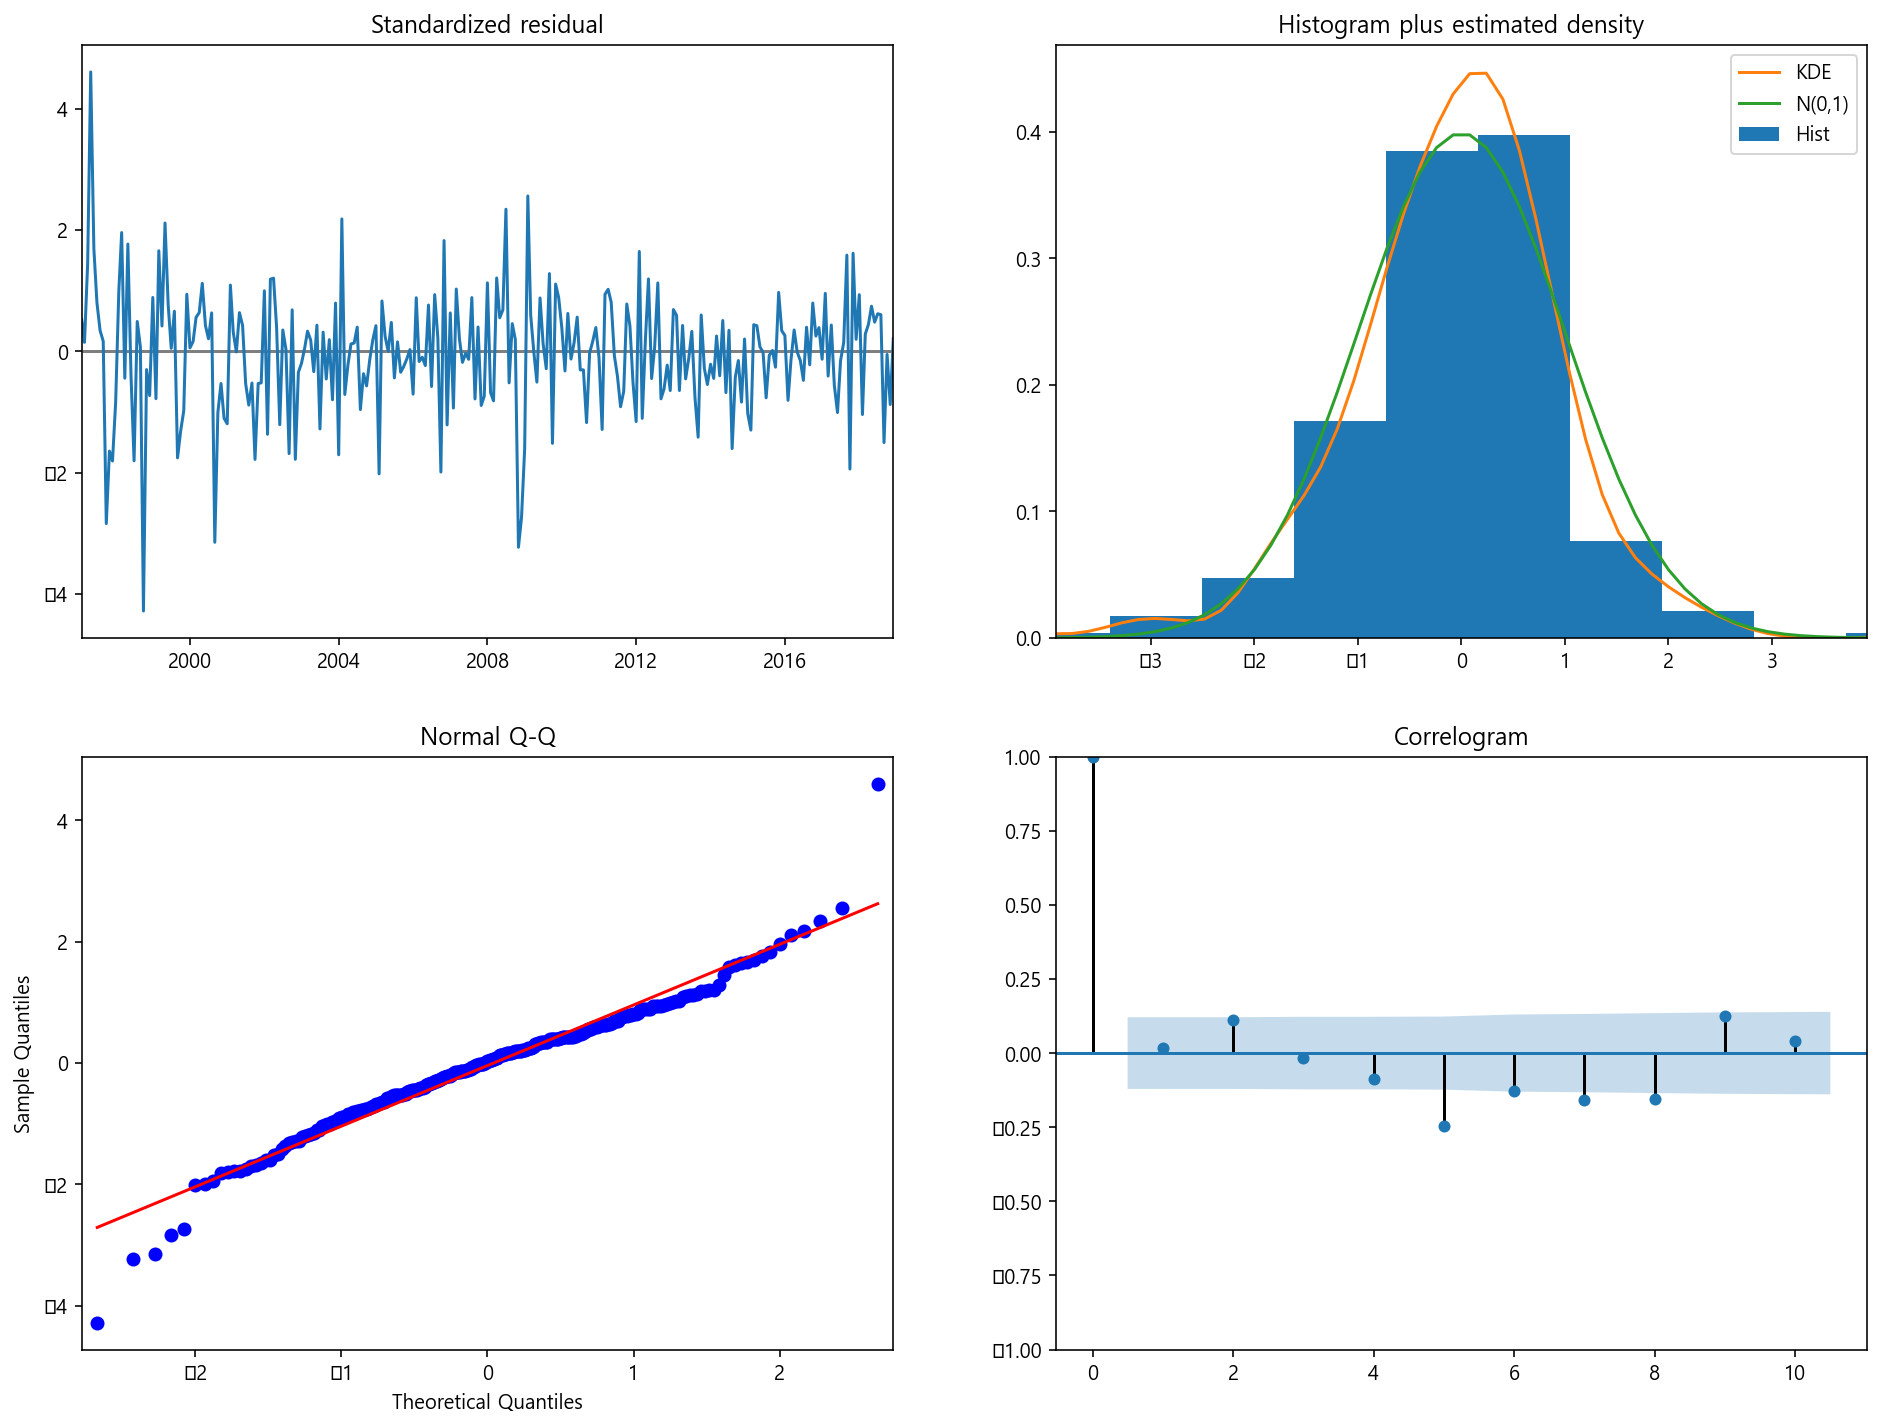

In [10]:
#모형 진단
model_arima.plot_diagnostics(figsize=(16,12));

In [7]:
import warnings
warnings.filterwarnings('ignore')

11.519799191481829


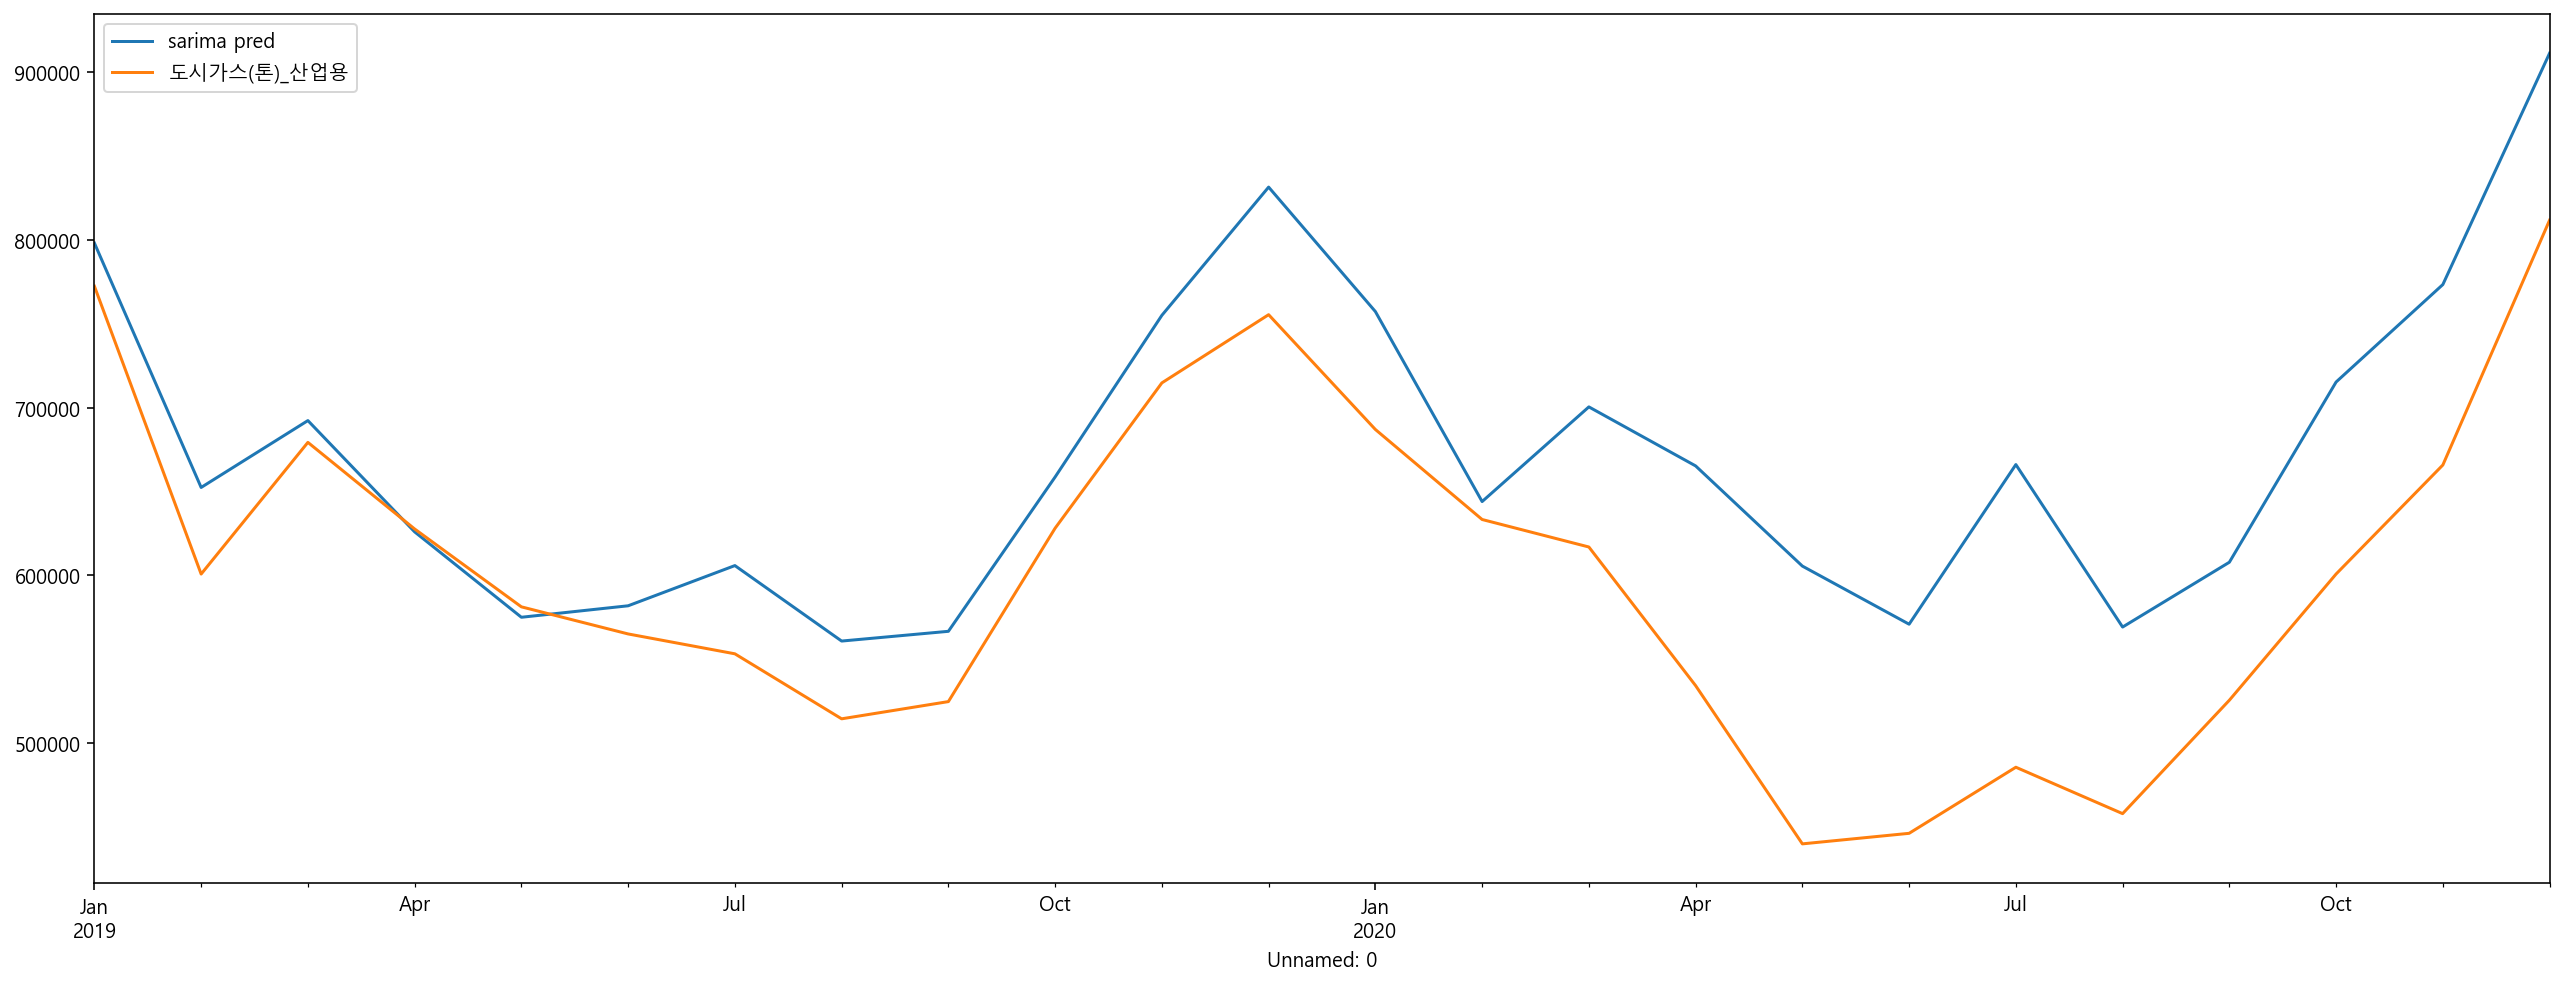

In [11]:
model=SARIMAX(np.log1p(train['도시가스(톤)_산업용']),order=(1,1,0),seasonal_order=(0,1,[1],12),exog=train['temp'])
results=model.fit()
pred = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels',exog=test['temp']).rename('sarima pred')
plt.figure(figsize=(22,8))
np.expm1(pred).plot(legend=True);
test['도시가스(톤)_산업용'].plot(legend=True);
print(smape(test['도시가스(톤)_산업용'],np.expm1(pred)))

# Forecast

In [12]:
final_pred=results.predict(start=len(train), end=len(train)+len(sample_submission)-1, dynamic=False, typ='levels',exog=sample_submission['TEMP'])[-168:]
sample_submission['IND']=np.expm1(final_pred).values

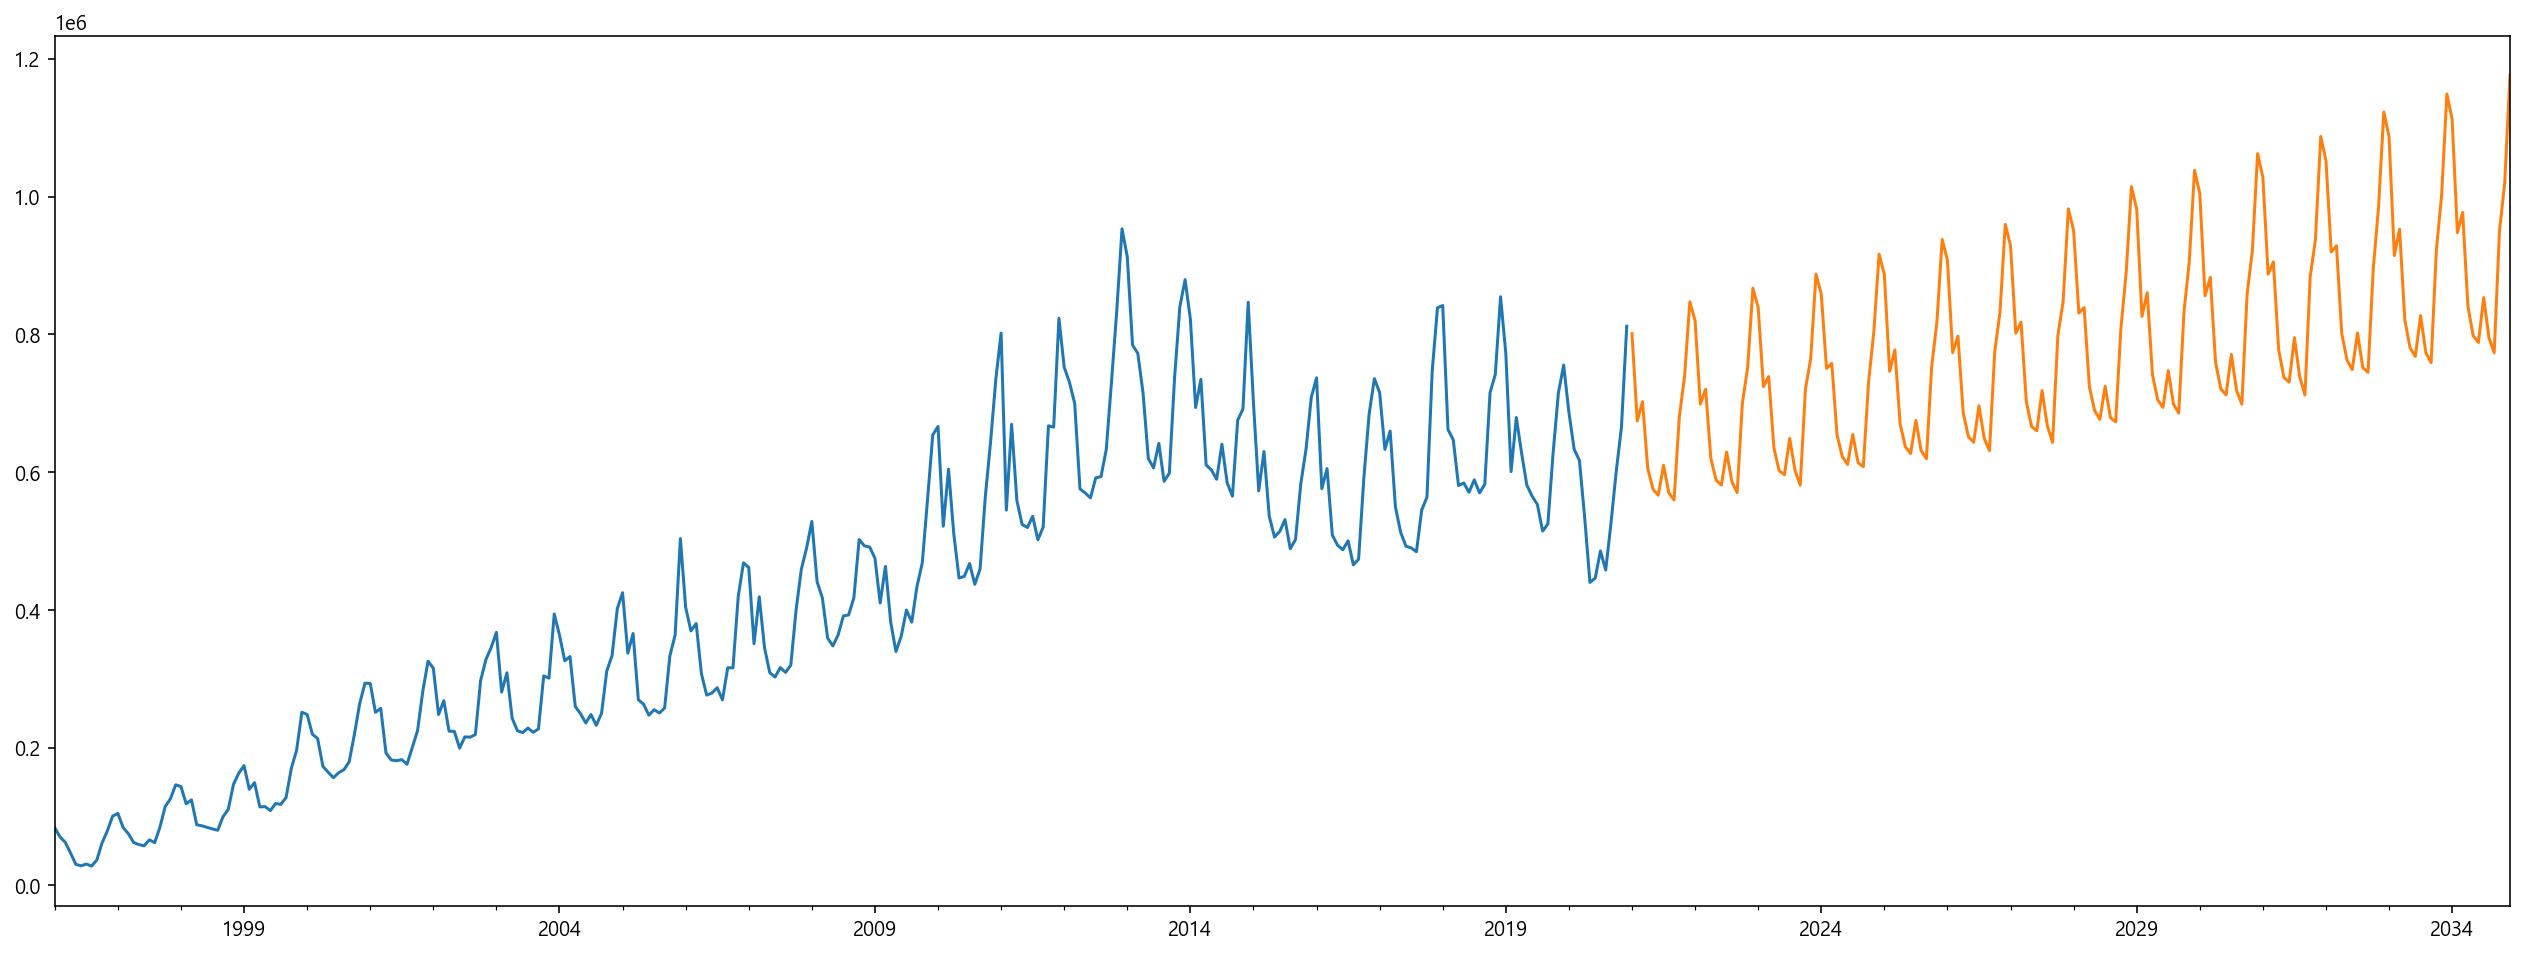

In [10]:
#sample_submission timestamp에 맞게 수정
final_pred.index = pd.date_range('2021-01-01','2034-12-01',freq='MS')
plt.figure(figsize=(22,8))
df['도시가스(톤)_산업용'].plot()
np.expm1(final_pred).plot()

In [12]:
# #model save
# with open('model_ind.pickle','wb') as fw:
#     pickle.dump(model, fw)

# CIVIL

In [14]:
model_arima=auto_arima(train['도시가스(톤)_민수용'], trace=True,m=12,D=1,random_state=42,scoring='mae',suppress_warnings=True,information_criterion='bic',
                      n_jobs=-1,maxiter=100)
model_arima.fit(train['도시가스(톤)_민수용'])

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : BIC=6811.098, Time=1.70 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : BIC=6853.196, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : BIC=6791.754, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : BIC=6815.209, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : BIC=6869.674, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : BIC=6820.418, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : BIC=6796.548, Time=1.24 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : BIC=6795.931, Time=0.47 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : BIC=6792.700, Time=0.30 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : BIC=6801.502, Time=1.90 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : BIC=6850.655, Time=0.40 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : BIC=6795.521, Time=0.34 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : BIC=6795.455, Time=0.46 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : BIC=6814.720, Time=0.21 sec
 ARIMA(2,0,1)(1,1,0

ARIMA(maxiter=100, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mae', scoring_args={}, seasonal_order=(1, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [15]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  276
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -3384.725
Date:                            Thu, 01 Dec 2022   AIC                           6777.450
Time:                                    13:10:13   BIC                           6791.754
Sample:                                         0   HQIC                          6783.198
                                            - 276                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.85e+04   6775.457      2.730      0.006    5216.633    3.18e+04
ar.L1          0.4926      0.043     11.572      0.000       0.409       0.576
ar.S.L12      -0.3469      0.045     -7.668      0.000      -0.436      -0.258
sigma2       9.13e+09      0.027   3.41e+11      0.000    9.13e+09    9.13e+09
===================================================================================
Ljung-Box (Q):                       69.02   Jarque-Bera (JB):               104.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.01   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.78e+31. Standard errors may be unstable.
"""

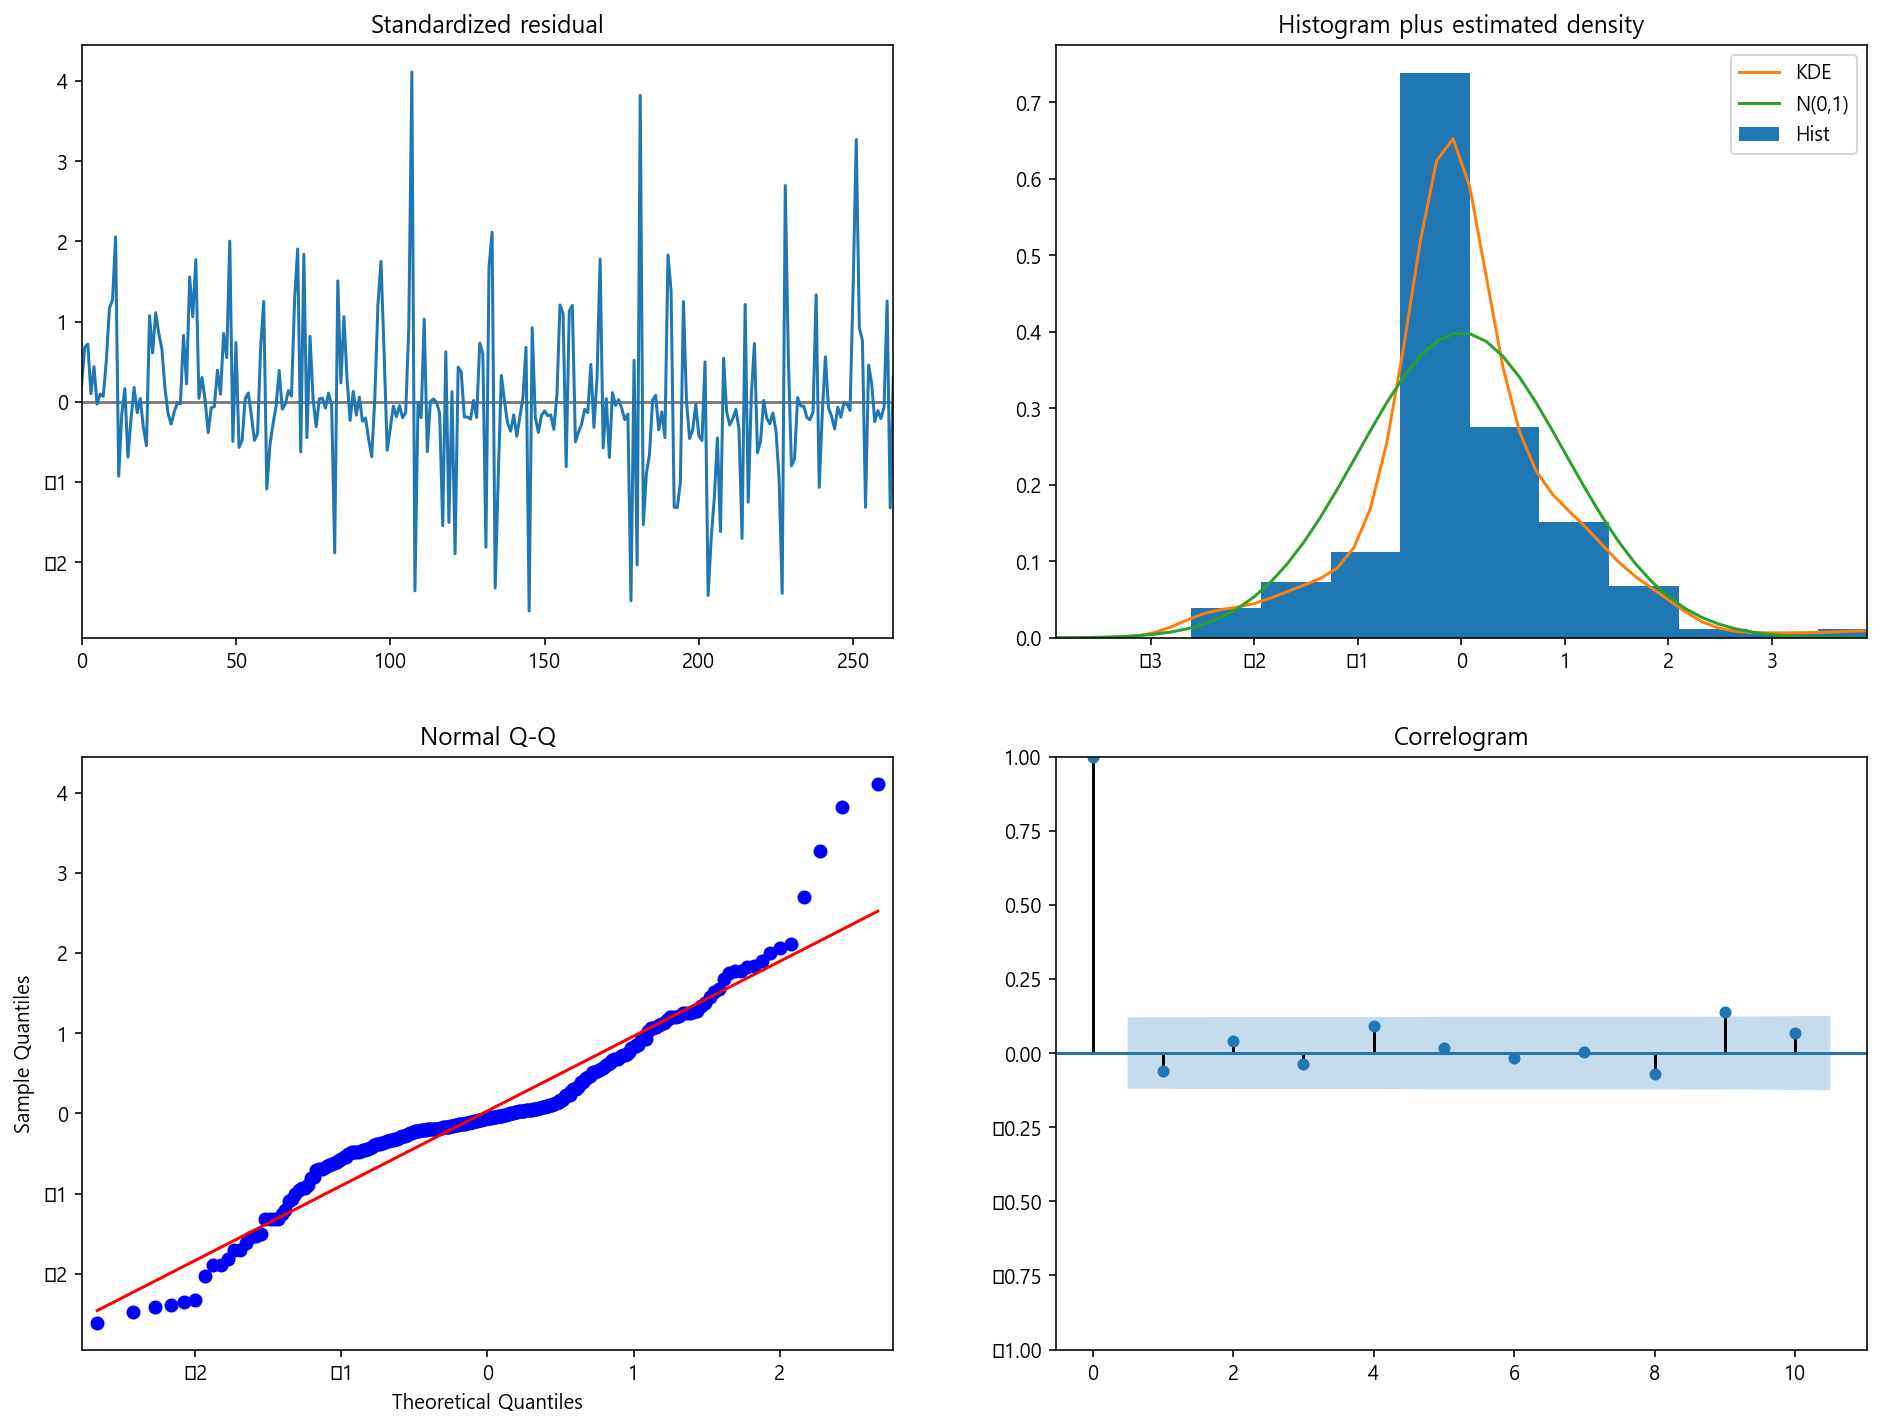

In [15]:
model_arima.plot_diagnostics(figsize=(16,12));

SARIMAX(1, 0, 0)x(1, 1, 0, 12) 모형이 정규성을 만족하지 못하여 새로운 값에 대한 예측을 잘 못하게 됩니다.  
**민수용은 log Transformation , boxcox Transformation,Differencing,외부변수 투입을 교차실험을 진행하였습니다.**  
다른 방법으로 해볼 필요가 있습니다.

4.943351743239144


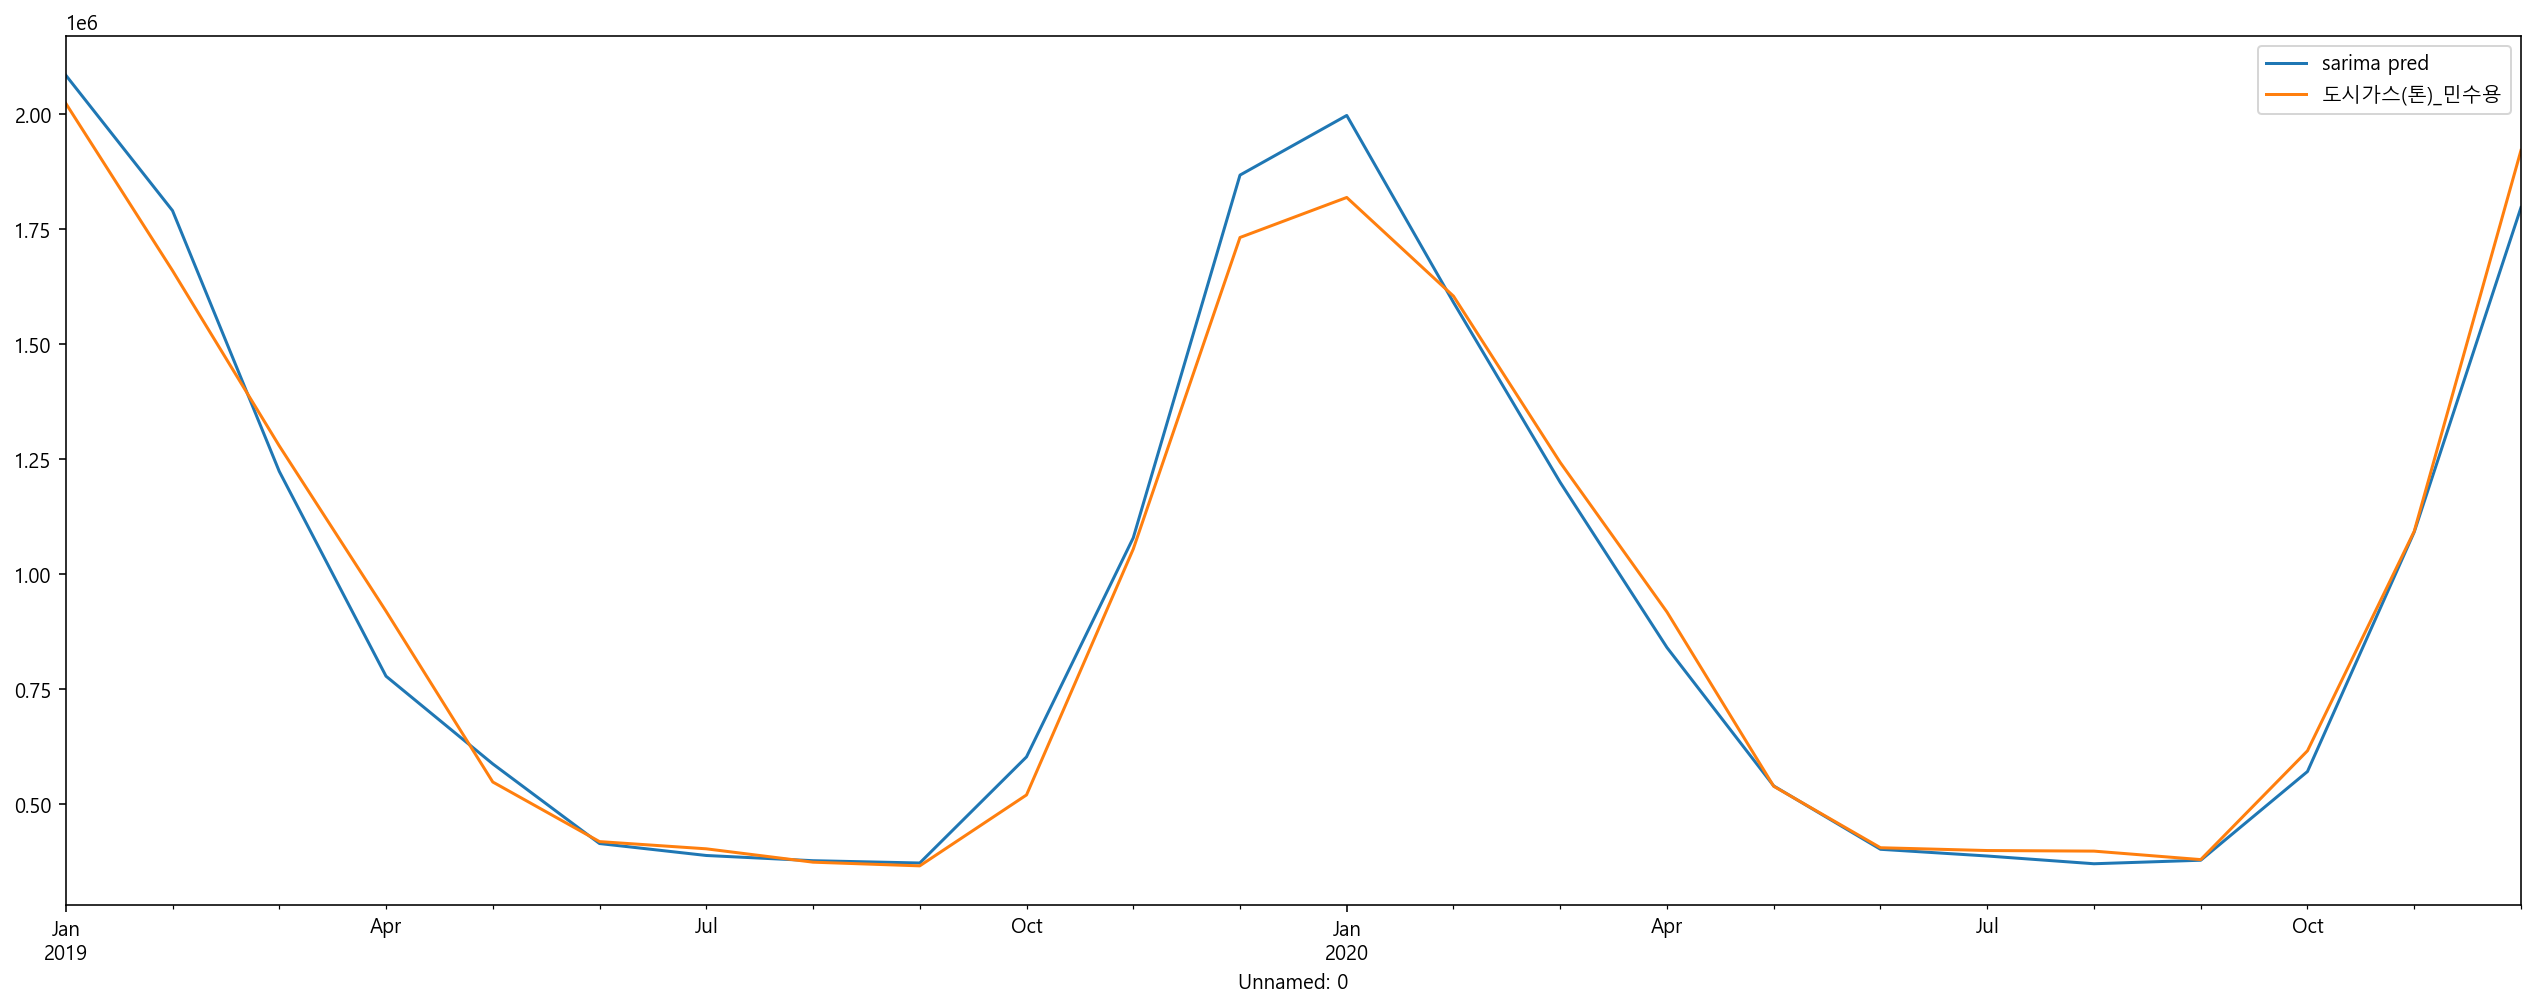

In [17]:
#계절성 차분으로 진행하고, (p,d,q) d=0으로 지정
model=SARIMAX(df['도시가스(톤)_민수용'],order=(4,0,1),seasonal_order=(1,1,0,12))
results=model.fit()
pred = results.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename('sarima pred')
plt.figure(figsize=(22,8))
pred.plot(legend=True);
test['도시가스(톤)_민수용'].plot(legend=True);
print(smape(test['도시가스(톤)_민수용'],pred))

# Forecast

In [18]:
final_pred=results.predict(start=len(train), end=len(train)+len(test)+len(sample_submission)-1, dynamic=False, typ='levels')[-168:]
sample_submission['CIVIL']=final_pred.values

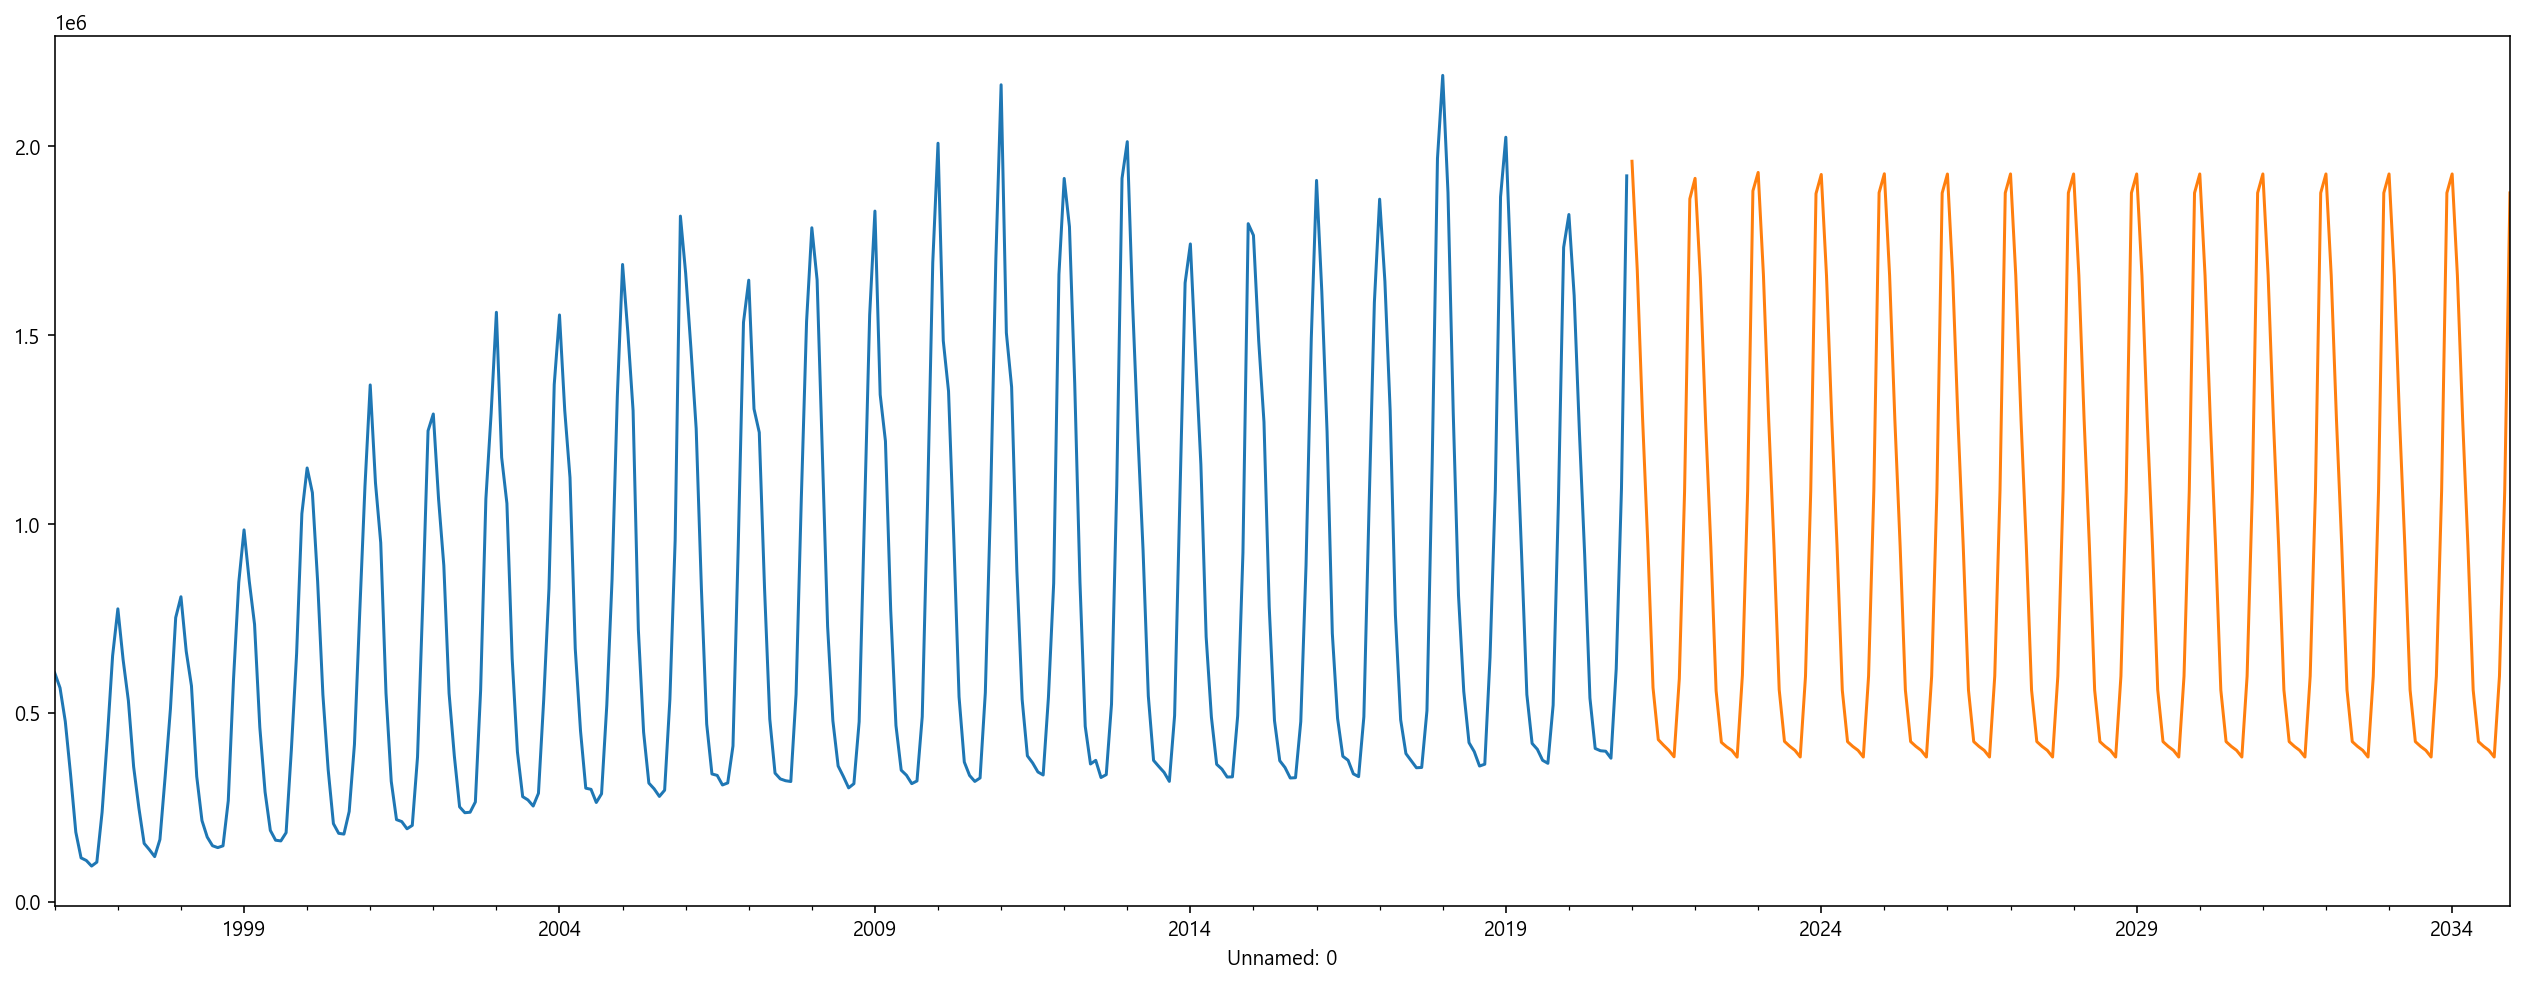

In [19]:
plt.figure(figsize=(22,8))
df['도시가스(톤)_민수용'].plot()
final_pred.plot()

In [19]:
# #model save
# with open('model_civil.pickle','wb') as fw:
#     pickle.dump(model, fw)

In [20]:
sample_submission

,YEAR,MONTH,CIVIL,IND,TEMP
0,2021,1,1960022.52054,801120.54026,-0.21642
1,2021,2,1673140.83247,674339.46098,1.03056
2,2021,3,1284483.27891,702461.04670,6.73063
3,2021,4,949874.20740,605318.60827,12.79301
4,2021,5,566865.47314,575320.03123,18.38720
...,...,...,...,...,...
163,2034,8,400932.70934,795268.04204,26.09956
164,2034,9,383354.70515,773542.31689,22.83457
165,2034,10,597411.05990,949943.53777,15.04975
166,2034,11,1087850.84775,1020148.60404,10.07151


In [21]:
sample_submission.iloc[:,:4].to_csv("Z:/team/submission2/final_submission.csv",index=False)